# Navigation Project report

A number of different agents were created to solve the 'Banana Navigation' game. A combination of These were:

1. Basic Deep Queue Network using experience replay, using a linear neural network model
2. Similar to 1, but including a 'Double' network
3. Building on 2, but also including a 'Dueling' network
4. Prioritised experience replay

All of these implementations 'solved' the solution in so much as they achieved an average score over 100 episodes > 13. Results of these are shown below.




## Architected for experimenting

The code implemented can be broadly broken down into three main areas:
- Agents classes
- NN models classes
- Experience Replay buffers classes

The goal is that these three elements can be mixed and matched in order to make it easy to experiment with different configurations.

So for example a different neural network model could be implemented and easily tested with both a normal experience replay buffer or a prioritised replay buffer and both of these configurations could utilise Double Q-Learning or not.

### Agents
A base agent class (BaseAgent) was implemented to support some common methods and attributes. Two sub classes were created, one to support basic replay buffers and the other to support priority experience type replay buffers. Currently the type of replay buffer is hard-coded to the specific agent, but this could be parameterised.

### NN Models
Any model can be used in conjunction with any of the agents implemented. Three models have been implemented:
- Basic linear model with three layers. The number of units for the two hidden layers can be provided as parameters
- Dueling linear model
- Conv2d model, specifically for the image based state

For all networks the number of output units is equal to the number of actions, so a single forward pass can determine the action.

### Experience Replay buffers
Two replay buffers have been implemented:
- ReplayBuffer: simply stores experiences and samples randomly
- PrioritizedReplayBuffer: this uses a sumtree to manage the prioritized experiences.

#### Prioritized Replay Buffer
The experiences themselves are stored in an array, with the adjusted priorities stored in a sumtree. 

When an experience is added its priority is not initially known (as this will only happen when sampled). As described in the paper [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) all experiences should be sampled at least once, so these experiences are initially given a priority of 0 and put in a 'not prioritised' queue. When a request to provide a sample is made these unprioritised experiences will be provided before any other experiences. After an experience has been sampled its priority will be updated.

Priorities are adjusted by a constant, alpha as described in the paper.

Importance sampling weights are calculated when experiences are sampled and returned with the samples, so that the loss can be adjusted by these weights.

Both the alpha and beta (used in calculating importance sampling weights) constants are periodically adjusted. Alpha decaying slowly and beta annealing to 1. The constants for alpha and beta have been taken from the paper.

Sampling uses the priority of the experience. I divide the priority space into equal sized segments (batch size number of them) and then uniformally sample from these segments. I believe this is what the paper describes.



## Learning algorithms

A variety of approaches have been experimented with, these are described below.

### Experience replay
The fundamental approach adopted is described in the paper [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). The implementation uses two neural networks and an experience replay buffer.

### Double Q-learning
[Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/pdf/1509.06461.pdf) attempts to tackle the known problem of action values being overestimated in certain conditions. 
For DQN using the same values both to select and to evaluate an action makes it more likely that this overestimate will occur.
To prevent this the selection and evaluation of actions is decoupled. The selection of the action (using argmax) uses the local (online) network, whereas the evaluation uses the the target network.
In this implementation the base agent class (AgentBase) implements this feature so that it can be utilised independently of other features that may be used.

### Dueling network architectures
A duel network architecture as described in the paper [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/pdf/1511.06581.pdf) has been demonstrated to improve the performance of a reinforcment learning agent.
This approach has been implemented as the model DuelingQNetwork

### Prioritized Experience Replay
A prioritised experience replay buffer as described in the paper [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) has been implemented.



## Plots of rewards for different agents

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import json
from lib.agents import AgentExperienceReplay, AgentPrioritizedExperienceReplay
from lib.models import QNetwork, DuelingQNetwork


#env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name="Banana.app")


# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

import matplotlib.pyplot as plt
%matplotlib inline

from lib.dqn import dqn

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

def create_dueling_model(state_size, action_size, seed):
    return DuelingQNetwork(state_size, action_size, seed)

def create_linear_model(state_size, action_size, seed):
    return QNetwork(state_size, action_size, seed)

all_scores = {}

all_scores_filename = 'scores.json'

def load_scores_from_file():
    with open(all_scores_filename) as fp:
        all_scores = json.load(fp)

def save_scores_to_file():
    with open(all_scores_filename, 'w') as fp:
        json.dump(all_scores, fp, sort_keys=True, indent=4)
        
load_scores_from_file()
if not all_scores:
    all_scores = {}


In [ ]:
2 + 3

### Dueling Network with Double Q-learning and Prioritized experience replay

Episode 100	Average Score: 12.72


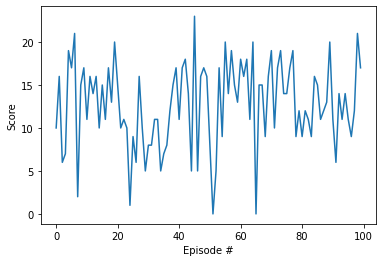

In [2]:
agent_name = 'prioritized_experiences_dueling_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                         create_model=create_dueling_model,
                                         double_dqn=True,
                                         train_mode=False
                                         )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


### Dueling Network with Prioritized experience replay

Episode 100	Average Score: 10.43


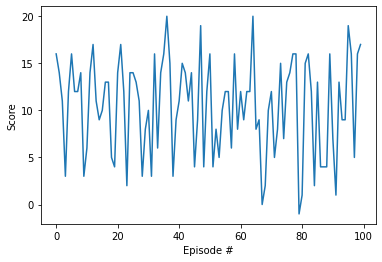

In [3]:

agent_name = 'prioritized_experiences_dueling_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                         create_model=create_dueling_model,
                                         double_dqn=False,
                                         train_mode=False
                                         )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Prioritized experience replay

Episode 100	Average Score: 13.49


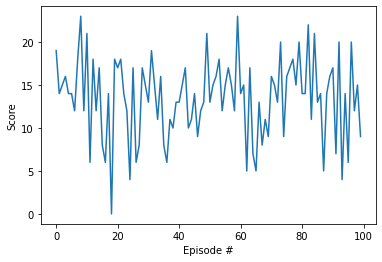

In [4]:

agent_name = 'prioritized_experiences_linear_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                             create_model=create_linear_model,
                                             double_dqn=False,
                                             train_mode=False
                                             )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Double Q-learning and Prioritized experience replay

Episode 100	Average Score: 13.91


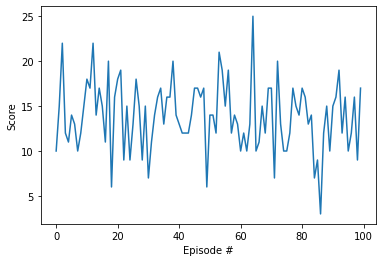

In [5]:
agent_name = 'prioritized_experiences_linear_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                             create_model=create_linear_model,
                                             double_dqn=True,
                                             train_mode=False
                                             )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Dueling Network with Double Q-learning random experience replay

Episode 100	Average Score: 13.96


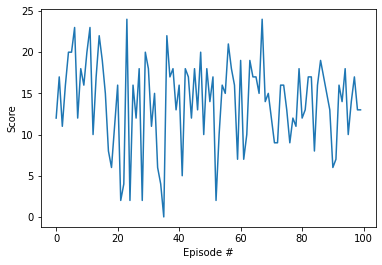

In [6]:

agent_name = 'uniform_experiences_dueling_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_dueling_model,
                                  double_dqn=True,
                                  train_mode=False
                                  )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Dueling Network  random experience replay

Episode 100	Average Score: 14.41


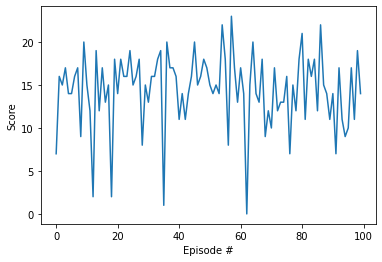

In [7]:

agent_name = 'uniform_experiences_dueling_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_dueling_model,
                                  double_dqn=False,
                                  train_mode=False
                                 )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Double Q-learning random experience replay

Episode 100	Average Score: 17.10


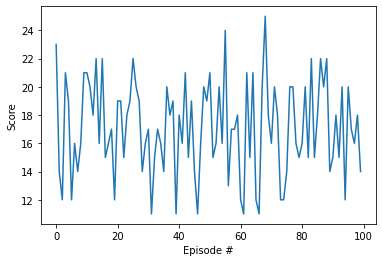

In [8]:

agent_name = 'uniform_experiences_linear_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_linear_model,
                                  double_dqn=True,
                                  train_mode=False
                                 )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with random experience replay

Episode 100	Average Score: 14.74


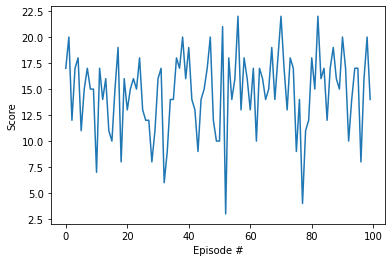

In [9]:

agent_name = 'uniform_experiences_linear_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_linear_model,
                                  double_dqn=False,
                                  train_mode=False
                                  )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Ideas for future work

### Experiment with a greater variety of network models
A lot more experimenting with different models is needed, I really didn't delve into this sufficiently due to time spent implementing the various algorthims described above.

### Using a DQN to 'learn' the best parameters

It feels like there is a lot of trial and error in order to determine the best architecture (e.g. network model, double q-learning etc) and hyperparameters. Would it be possible to define a DQN that could be used to determine what were the best set of values. Parameter values could be limited to discrete values so that the state space was managable. The reward could be the average score from a number of episodes of the game.

### Effective testing of subcomponents

With a lot of software, bugs are very obvious. With ML code it's possible to implement features, e.g. prioritized experience replay, which appear to 'work', in so much that the agent learns, but the implementation may not perform as intended. Whilst this issue is not limited to ML code, it does seem particularly vulnerable as some components may be difficult to verify.

### Image based navigation (pixel navigation)

I started to explore using an image of the game as the state, although ran out of time to actually solve it. I did wonder if you used a different reward than that provided by the environment. For example what if the reward was based on how yellow or blue (perhaps using the dot product to measure the yellowness/blueness), how would this effect the performance of the agent.
